# Hopkins-COVID

## Description

Download and visualize the latest COVID-19 data from John Hopkins University. There's nothing original about the visualizations, but there's a useful wrapper function to extract time series for a specific country, state, county, or combination thereof as a pandas dataframe.

## Features

- Automatic download of latest data using gitpython.
- Wrapper function to extract time series for any geographical region. Specify a country/state/county to get a dataframe for that region. Add/subtract those dataframes to get the data for a composite region.
- Visualization of daily cases and deaths time series using matplotlib. The graphic design was inspired by the visualizations from French newspaper *Le Monde*.
- Visualization of cumulative deaths across the world as an interactive map using mplleaflet.

## Author

Yaouen Fily

In [1]:
import glob, os, sys, git, datetime, dateparser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplleaflet

In [2]:
pd.plotting.register_matplotlib_converters()
plt.rcParams['figure.figsize'] = 12,4
plt.rcParams['font.size'] = 14


# Collect Data

Get the latest version of the John Hopkins COVID-19 dataset from github (https://github.com/CSSEGISandData/COVID-19.git). The dataset is several hundred MB, so it can take a while the first time.

In [3]:
# Get latest COVID data from git repository.
print('Fetching latest data...')
try:
    # If the repo exists, update it.
    repo = git.Repo('COVID-19')
    repo.remote().pull()
except:
    # If the repo doesn't exists, create it.
    repo = git.Repo.clone_from('https://github.com/CSSEGISandData/COVID-19.git', 'COVID-19')
# print(repo.git.status())

# Create a dictionary of dataframes, one for each daily report, indexed by date.
print('Loading daily reports...')
daily_report_files = glob.glob('COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/*.csv')
daily_reports = {}
for fn in daily_report_files:
    date = dateparser.parse(os.path.splitext(os.path.basename(fn))[0])
    daily_reports[date] = pd.read_csv(fn)
dates = sorted(daily_reports.keys())

# Rename location columns to make them consistent across the entire period.
print('Pre-processing daily reports...')
for k,df in daily_reports.items():
    df = df.rename(columns={'Latitude':'Lat','Longitude':'Long','Long_':'Long',
                            'Country/Region':'country', 'Country_Region':'country', 
                            'Province/State':'state', 'Province_State':'state',
                            'Admin2':'county'
                           })
    # Add a dummy 'county' column to older daily reports.
    if not 'county' in df.columns:
        df['county'] = 'none'
    # Replace nonexistent location information with 'none' so the rows
    # don't get ignored when using e.g. 'groupby'.
    for n in 'country','state','county':
        df.loc[df[n].isna(),n] = 'none'
    # Add 'active' column.
    df['Active'] = df['Confirmed']-df['Deaths']-df['Recovered']
    
    daily_reports[k] = df.copy()

print('Done.')
# display(daily_reports[dates[0]])

Fetching latest data...
Loading daily reports...
Pre-processing daily reports...
Done.


In [4]:
# # Not currently using this anywhere. The idea was to compute cases 
# # per 100,000 inhabitants using census data from the census bureau.

# population = pd.read_csv('census_population.csv',encoding='latin-1')
# population = population[['STNAME','CTYNAME','POPESTIMATE2019']]
# population = population.rename(columns={'STNAME':'state','CTYNAME':'county','POPESTIMATE2019':'population'})
# # population

# # # Look for counties not named "??? County".
# # [c for c in population['county'] if not ' County' in c]

# # # Look for duplicate counties (same name in multiple states).
# # counties = population['county']
# # count = sorted([ (sum(counties==c),c) for c in np.unique(counties) ])
# # for i in range(1,5):
# #     print(count[-i])

# Time series for a country/state/county

In [5]:
# Function to access the time series from a specific country, state, or county.
def get_region_data(daily_reports=daily_reports, dates=dates, start_date=None, **region_dict):
    data = {}
    if start_date:
        dates = [ d for d in dates if d>start_date ]
    for date in dates:
        df = daily_reports[date]
        I  = pd.Series(True,index=df.index)
        for k,v in region_dict.items():
            I = I & (df[k]==v)
        data[date] = df[I][['Confirmed','Deaths','Recovered','Active']].sum(axis=0).astype(int)
    return pd.DataFrame(data).T

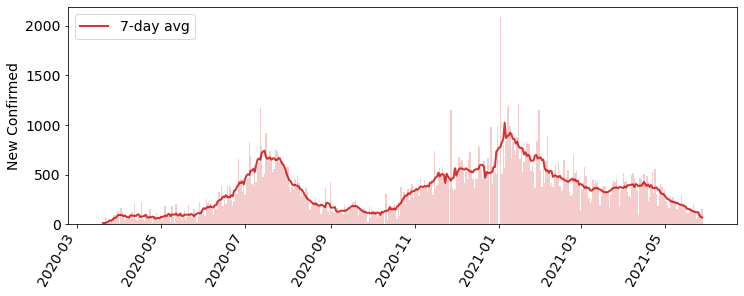

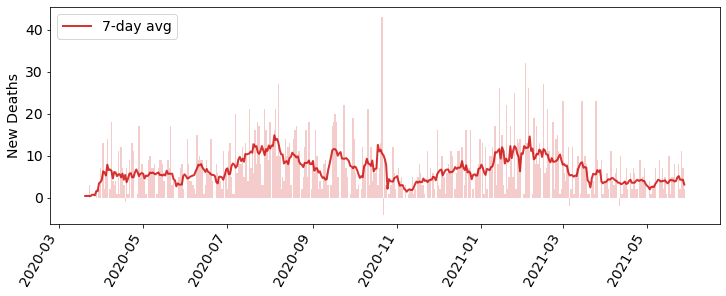

In [6]:
for c in ['Confirmed','Deaths']:

#     df  = get_region_data(country='US')
#     df  = get_region_data(state='Florida')
    df  = get_region_data(county='Palm Beach')

#     # Note: You can get combine regions by adding/subtracting get_region_data outputs.
#     # Here is North America:
#     df = get_region_data(country='Canada')+get_region_data(country='US')+get_region_data(country='Mexico')
#     # Here is the US except New York State.
#     df = get_region_data(country='US')-get_region_data(state='New York')

    df  = df[c] # Only the relevant column.
#     df  = df[-90:] # Only the last 90 days.
    df  = df[df.index.map(lambda t: t>datetime.datetime(2020,3,15))] # Only after 3/15/2020.

    w   = 7 # moving average window size
    diff = df.diff()
    mAvg = diff.rolling(window=w,center=True).mean()

    color = (0.8,0,0)
    width = pd.to_timedelta('24:00:00')
    plt.bar(diff.index,diff.values,width=width,color=color,alpha=0.2)
    plt.plot(mAvg,label=f'{w}-day avg',lw=2,color=color,alpha=0.8)

    plt.legend(loc='upper left')
    plt.ylabel(f'New {c}')
#     plt.ylim(0,None)
    plt.xticks(rotation=60,ha='right')
    plt.show()

# Map

In [7]:
''' Retrieve a daily report. '''
# Make a deep copy to avoid modifying the original dictionary of dataframes.
report = daily_reports[dates[-1]].copy()

# ''' Group data by country. '''
# # If the country has subdivisions, use the lat/long of the one with the most cases.
# gb  = report.groupby(['country'])
# I   = gb['Confirmed'].idxmax()
# df1 = report.loc[I.values][['country','Lat','Long']]
# df2 = gb[['Confirmed','Deaths','Recovered','Active']].sum()
# df1.index = df2.index
# by_country = pd.concat([df1,df2],axis=1)
# # by_country.to_csv('map_data_by_country.csv')

''' Group data by state. '''
# Treat countries without subdivisions as states.
# If a state has subdivisions, use the average lat/long.
gb  = report.groupby(['country','state'])
df1 = gb[['Lat','Long']].mean()
df2 = gb[['Confirmed','Deaths','Recovered','Active']].sum()
by_state = pd.concat([df1,df2],axis=1)
# by_state.to_csv('map_data_by_state.csv')

In [8]:
# df = by_country
df = by_state

df = df.dropna()
size = df['Deaths'] # Show cumulated deaths.
size = 2e3*size/size.max()
# size = 10*np.log(1+size)

plt.figure(figsize=(10,10))
plt.scatter(df['Long'],df['Lat'],s=size,alpha=0.5) #,edgecolors='none')
mplleaflet.display()

/home/yaouen/software/miniconda3/envs/main/lib/python3.6/site-packages/IPython/core/display.py:717: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")
